## Import Libraries

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from collections import Counter
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

## Import Dataset

In [51]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,NaN,https://www.northcm.ac.th,24.0,www.northcm.ac.th,17.0,0.0,NaN,0.800000,NaN,...,0.0,0.0,1.0,NaN,3.0,NaN,69.0,NaN,NaN,1
1,4,8135291.txt,http://uqr.to/1il1z,NaN,NaN,NaN,NaN,to,1.000000,0.000896,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0
2,5,586561.txt,https://www.woolworthsrewards.com.au,35.0,www.woolworthsrewards.com.au,28.0,0.0,au,0.857143,NaN,...,1.0,0.0,1.0,33.0,7.0,8.0,15.0,NaN,2.0,1
3,6,NaN,NaN,31.0,NaN,NaN,NaN,com,0.562500,0.522907,...,1.0,0.0,1.0,24.0,5.0,14.0,NaN,NaN,NaN,1
4,11,412632.txt,NaN,NaN,www.nyprowrestling.com,22.0,0.0,NaN,1.000000,NaN,...,0.0,0.0,1.0,NaN,NaN,14.0,NaN,0.0,NaN,1


In [52]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
0,48,80851.txt,https://www.iaee.org,19.0,NaN,12.0,0.0,org,NaN,0.079963,...,1.0,0.0,0.0,1.0,NaN,NaN,13.0,194.0,NaN,65.0
1,68,mw130480.txt,http://www.iran-edi.com,22.0,NaN,16.0,NaN,NaN,0.625000,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,2.0,0.0,0.0,1.0
2,76,400382.txt,https://www.bistum-chur.ch,25.0,www.bistum-chur.ch,18.0,0.0,ch,0.636364,0.004983,...,NaN,NaN,0.0,1.0,5.0,12.0,18.0,193.0,NaN,196.0
3,155,625297.txt,https://www.numberthreebath.com,30.0,NaN,23.0,NaN,com,1.000000,0.522907,...,0.0,0.0,NaN,NaN,NaN,1.0,10.0,12.0,0.0,11.0
4,167,8123642.txt,https://ipfs.litnet.work/ipfs/bafybeib5jvxytzb...,100.0,ipfs.litnet.work,NaN,0.0,work,NaN,NaN,...,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [53]:
def convert_data_types(df):
    #mengganti column float yang seperti boolean menjadi boolean
    for col in df.select_dtypes(include=['float64']).columns:
        #menghilangkan value kosong agar bisa mengecek 0.0 atau 1.0
        if df[col].dropna().isin([0.0, 1.0]).all():
            #jika column hanya berisi 0.0 dan 1.0, merubah ke tipe boolean
            df[col] = df[col].astype('boolean')

    #mengganti column int yang seperti boolean menjadi boolean
    for col in df.select_dtypes(include=['int64']).columns:
        #menghilangkan value kosong agar bisa mengecek 0.0 atau 1.0
        if df[col].dropna().isin([0, 1]).all():
            #jika column hanya berisi 0.0 dan 1.0, merubah ke tipe boolean
            df[col] = df[col].astype('boolean')

    #mengecek column apakah column float bisa diubah ke int
    for col in df.select_dtypes(include=['float64']).columns:
        #mengecek apakah baris yang tidak kosong adalah bilangan bulat
        if (df[col].dropna() == df[col].dropna().astype('int64')).all():
            #mengubah menjadi tipe integer jika terpenuhi
            df[col] = df[col].astype('Int64')  #menggunakan 'Int64' untuk bisa untuk column kosong

In [54]:
convert_data_types(df_train)
print(df_train.dtypes)

convert_data_types(df_test)
print(df_test.dtypes)

id                              int64
FILENAME                       object
URL                            object
URLLength                       Int64
Domain                         object
DomainLength                    Int64
IsDomainIP                    boolean
TLD                            object
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       Int64
NoOfSubDomain                   Int64
HasObfuscation                boolean
NoOfObfuscatedChar              Int64
ObfuscationRatio              float64
NoOfLettersInURL                Int64
LetterRatioInURL              float64
NoOfDegitsInURL                 Int64
DegitRatioInURL               float64
NoOfEqualsInURL                 Int64
NoOfQMarkInURL                  Int64
NoOfAmpersandInURL              Int64
NoOfOtherSpecialCharsInURL      Int64
SpacialCharRatioInURL         float64
IsHTTPS                       boolean
LineOfCode  

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

In [55]:
train_set, val_set = train_test_split(df_train,test_size=0.25, random_state=42)

# check
print(train_set.shape)
print(val_set.shape)

(105303, 56)
(35101, 56)


In [56]:
train_set.nunique()

id                            105303
FILENAME                       62287
URL                            72823
URLLength                        196
Domain                         52431
DomainLength                      76
IsDomainIP                         2
TLD                              453
CharContinuationRate             421
TLDLegitimateProb                393
URLCharProb                    65739
TLDLength                         10
NoOfSubDomain                      6
HasObfuscation                     2
NoOfObfuscatedChar                 6
ObfuscationRatio                  24
NoOfLettersInURL                 176
LetterRatioInURL                 473
NoOfDegitsInURL                   76
DegitRatioInURL                  349
NoOfEqualsInURL                   13
NoOfQMarkInURL                     4
NoOfAmpersandInURL                14
NoOfOtherSpecialCharsInURL        42
SpacialCharRatioInURL            171
IsHTTPS                            2
LineOfCode                      7477
L

# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

### Teknik Handling Missing data
- Menggunakan dua metode imputasi, yaitu most_frequent dan mean, untuk menangani nilai yang hilang (missing values) pada dataset. Imputasi dengan strategi most_frequent digunakan untuk kolom bertipe object dan boolean, karena tipe data ini biasanya berisi nilai kategori atau True/False, sehingga pengisian dengan nilai yang paling sering muncul (modus) adalah pendekatan yang masuk akal. Sementara itu, strategi mean digunakan untuk kolom bertipe numerik, yaitu float64 dan Int64, karena pengisian nilai yang hilang dengan rata-rata dapat menjaga distribusi data numerik tetap konsisten.

In [57]:
def missingDataHandler(dataset) :
    dataset_copy = dataset.copy()

    imputer_modus = SimpleImputer(strategy='most_frequent')
    imputer_mean  = SimpleImputer(strategy='mean')

    dataset_object = dataset.select_dtypes(include='object').columns
    boolean_dataset = dataset.select_dtypes(include='boolean').columns
    float_dataset = dataset.select_dtypes(include='float64').columns
    int_dataset = dataset.select_dtypes(include='Int64').columns

    dataset[dataset_object]  = imputer_modus.fit_transform(dataset[dataset_object])
    dataset[int_dataset]     = np.ceil(imputer_mean.fit_transform(dataset[int_dataset]))
    dataset[float_dataset]   = imputer_mean.fit_transform(dataset[float_dataset])
    dataset[boolean_dataset] = imputer_modus.fit_transform(dataset[boolean_dataset])

    #mengubah kembali datatype menjadi semua (dari object)
    for col in dataset_copy.columns:
        dataset[col] = dataset[col].astype(dataset_copy[col].dtype)


In [58]:
missingDataHandler(train_set)
missingDataHandler(val_set)
train_set

train_set.isna().sum()

id                            0
FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
URLTitle

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [59]:
train_set.nunique()

id                            105303
FILENAME                       62287
URL                            72823
URLLength                        196
Domain                         52431
DomainLength                      76
IsDomainIP                         2
TLD                              453
CharContinuationRate             422
TLDLegitimateProb                394
URLCharProb                    65740
TLDLength                         10
NoOfSubDomain                      6
HasObfuscation                     2
NoOfObfuscatedChar                 7
ObfuscationRatio                  25
NoOfLettersInURL                 176
LetterRatioInURL                 474
NoOfDegitsInURL                   76
DegitRatioInURL                  350
NoOfEqualsInURL                   13
NoOfQMarkInURL                     4
NoOfAmpersandInURL                14
NoOfOtherSpecialCharsInURL        42
SpacialCharRatioInURL            172
IsHTTPS                            2
LineOfCode                      7477
L

In [60]:
numerical_train_set = train_set.select_dtypes(include='number').columns
for col in numerical_train_set :
    print(f'min {col} : {train_set[col].min()}')
print('\n')
for col in numerical_train_set :
    print(f'max {col} : {train_set[col].max()}')

min id : 4
min URLLength : 14
min DomainLength : 4
min CharContinuationRate : 0.0
min TLDLegitimateProb : 0.0
min URLCharProb : 0.001229244
min TLDLength : 2
min NoOfSubDomain : 0
min NoOfObfuscatedChar : 0
min ObfuscationRatio : 0.0
min NoOfLettersInURL : 0
min LetterRatioInURL : 0.0
min NoOfDegitsInURL : 0
min DegitRatioInURL : 0.0
min NoOfEqualsInURL : 0
min NoOfQMarkInURL : 0
min NoOfAmpersandInURL : 0
min NoOfOtherSpecialCharsInURL : 0
min SpacialCharRatioInURL : 0.0
min LineOfCode : 2
min LargestLineLength : 23
min DomainTitleMatchScore : 0.0
min URLTitleMatchScore : 0.0
min NoOfPopup : 0
min NoOfiFrame : 0
min NoOfImage : 0
min NoOfCSS : 0
min NoOfJS : 0
min NoOfSelfRef : 0
min NoOfEmptyRef : 0
min NoOfExternalRef : 0


max id : 235795
max URLLength : 4054
max DomainLength : 93
max CharContinuationRate : 1.0
max TLDLegitimateProb : 0.5229071
max URLCharProb : 0.088765828
max TLDLength : 11
max NoOfSubDomain : 5
max NoOfObfuscatedChar : 291
max ObfuscationRatio : 0.212
max NoOfLe

### Teknik Dealing with Outliers
- Menggunakan metode clipping. Pada kode ini, kami menangani outlier pada data numerik di dataset menggunakan metode IQR (Interquartile Range). Pertama, kami menghitung kuartil pertama (Q1) dan kuartil ketiga (Q3) untuk setiap kolom numerik, lalu menghitung IQR sebagai selisih antara Q3 dan Q1. Kemudian, kami menentukan batas bawah (lowerBound) dan batas atas (upperBound). Selanjutnya, nilai-nilai yang berada di luar batas tersebut dianggap outlier dan di-clip agar berada dalam rentang batas bawah dan atas. Untuk tipe data Int64, batas bawah dan atas dibulatkan menggunakan np.floor dan np.ceil agar konsisten dengan tipe datanya, sementara untuk tipe numerik lainnya tidak dilakukan pembulatan. Langkah ini bertujuan untuk menangani outlier secara efektif tanpa menghilangkan data, sehingga distribusi data tetap wajar untuk analisis atau pemodelan.

In [61]:
def outlierHandler(dataset) :
  numerical_dataset = dataset.select_dtypes(include='number').columns

  for i in numerical_dataset:
    Q1 = dataset[i].quantile(0.25)
    Q3 = dataset[i].quantile(0.75)

    IQR = Q3-Q1

    threshold = 1

    lowerBound = Q1 - (threshold*IQR)
    upperBound = Q3 + (threshold*IQR)

    # mean_value = train_set[i].mean()
    # train_set[i] = train_set[i].apply(lambda x: mean_value if (x < lowerBound or x > upperBound) else x)
    if (dataset[i].dtype == 'Int64') :
      dataset[i] = dataset[i].clip(lower=np.floor(lowerBound), upper=np.ceil(upperBound))
    else :
      dataset[i] = dataset[i].clip(lower=lowerBound, upper=upperBound)


In [62]:
outlierHandler(train_set)
outlierHandler(val_set)
train_set.nunique()

id                            105303
FILENAME                       62287
URL                            72823
URLLength                         10
Domain                         52431
DomainLength                      13
IsDomainIP                         2
TLD                              453
CharContinuationRate              49
TLDLegitimateProb                394
URLCharProb                    36206
TLDLength                          1
NoOfSubDomain                      4
HasObfuscation                     2
NoOfObfuscatedChar                 3
ObfuscationRatio                   3
NoOfLettersInURL                  10
LetterRatioInURL                  43
NoOfDegitsInURL                    3
DegitRatioInURL                    9
NoOfEqualsInURL                    3
NoOfQMarkInURL                     3
NoOfAmpersandInURL                 3
NoOfOtherSpecialCharsInURL         4
SpacialCharRatioInURL             27
IsHTTPS                            2
LineOfCode                      2426
L

In [63]:
numerical_train_set = train_set.select_dtypes(include='number').columns
for col in numerical_train_set :
    print(f'min {col} : {train_set[col].min()}')
print('\n')
for col in numerical_train_set :
    print(f'max {col} : {train_set[col].max()}')

min id : 4
min URLLength : 22
min DomainLength : 13
min CharContinuationRate : 0.8361015649028058
min TLDLegitimateProb : 0.0
min URLCharProb : 0.05529935250000001
min TLDLength : 3
min NoOfSubDomain : 0
min NoOfObfuscatedChar : 0
min ObfuscationRatio : 0.0
min NoOfLettersInURL : 9
min LetterRatioInURL : 0.45999999999999996
min NoOfDegitsInURL : 0
min DegitRatioInURL : 0.0
min NoOfEqualsInURL : 0
min NoOfQMarkInURL : 0
min NoOfAmpersandInURL : 0
min NoOfOtherSpecialCharsInURL : 0
min SpacialCharRatioInURL : 0.033106470669047955
min LineOfCode : 187
min LargestLineLength : 23
min DomainTitleMatchScore : 41.593227659395836
min URLTitleMatchScore : 42.282364967827846
min NoOfPopup : 0
min NoOfiFrame : 0
min NoOfImage : 0
min NoOfCSS : 0
min NoOfJS : 5
min NoOfSelfRef : 0
min NoOfEmptyRef : 0
min NoOfExternalRef : 0


max id : 235795
max URLLength : 31
max DomainLength : 25
max CharContinuationRate : 1.0
max TLDLegitimateProb : 0.5229071
max URLCharProb : 0.065176272
max TLDLength : 3
max 

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

### Teknik Remove Duplicates
- Menghapus duplikasi data berdasarkan kolom URL menggunakan metode drop_duplicates. Hal ini dilakukan karena setiap URL dalam dataset seharusnya unik. Jika terdapat URL yang sama dengan label yang sama, data tersebut tidak menambah informasi baru dan hanya meningkatkan redundansi. Sebaliknya, jika URL yang sama memiliki label yang berbeda (contoh: phishing dan non-phishing), hal ini dapat menyebabkan inkonsistensi data.

In [64]:
def duplicateHandler(dataset):
    dataset.drop_duplicates(subset=["URL"], inplace=True)

In [65]:
print("original: ")
print(train_set.shape)
print(val_set.shape)

duplicateHandler(train_set)
duplicateHandler(val_set)

print("after: ")
print(train_set.shape)
print(val_set.shape)

original: 
(105303, 56)
(35101, 56)
after: 
(72823, 56)
(24092, 56)


In [66]:
(train_set['label'] == 1).sum()

np.int64(67407)

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [67]:
train_set.nunique()

id                            72823
FILENAME                      43078
URL                           72823
URLLength                        10
Domain                        36286
DomainLength                     13
IsDomainIP                        2
TLD                             408
CharContinuationRate             45
TLDLegitimateProb               364
URLCharProb                   25068
TLDLength                         1
NoOfSubDomain                     4
HasObfuscation                    2
NoOfObfuscatedChar                3
ObfuscationRatio                  3
NoOfLettersInURL                 10
LetterRatioInURL                 41
NoOfDegitsInURL                   3
DegitRatioInURL                   8
NoOfEqualsInURL                   3
NoOfQMarkInURL                    3
NoOfAmpersandInURL                3
NoOfOtherSpecialCharsInURL        4
SpacialCharRatioInURL            27
IsHTTPS                           2
LineOfCode                     2416
LargestLineLength           

### Teknik Feature Engineering 
- Degan metode binning. Fungsi featureBinning digunakan untuk menyederhanakan nilai numerik dalam dataset menjadi kategori dengan melakukan proses binning. Kolom numerik, kecuali id, diubah menjadi tiga kategori: low, medium, dan high, berdasarkan nilai batas yang dihitung dari pembagian rentang minimum hingga maksimum menjadi tiga bagian yang sama besar. Setelah proses ini, kolom numerik asli dihapus, dan kolom baru hasil binning ditambahkan ke dataset dengan tipe data category untuk efisiensi memori dan pemrosesan. Proses ini membantu menyederhanakan data, mengurangi pengaruh outlier, dan mempermudah model dalam mengenali pola pada fitur dengan rentang nilai yang besar. Fungsi featureEngineeringHandler mengelola proses feature engineering, dengan menambahkan hasil binning ke dataset asli dan menghapus semua kolom bertipe object

In [68]:
def featureBinning(dataset):
    numerical_dataset = dataset[[col for col in dataset.select_dtypes(include='number').columns if col != 'id']].copy()
    old_columns = numerical_dataset.columns

    for col in numerical_dataset:
        min_val = numerical_dataset[col].min()
        max_val = numerical_dataset[col].max()
        val1 = min_val + ((max_val - min_val) // 3)
        val2 = min_val + ((max_val - min_val) * 2 // 3)

        numerical_dataset.loc[numerical_dataset[col] <= val1, 'bin_' + col] = 'low'
        numerical_dataset.loc[(numerical_dataset[col] > val1) & (numerical_dataset[col] <= val2), 'bin_' + col] = 'medium'
        numerical_dataset.loc[numerical_dataset[col] > val2, 'bin_' + col] = 'high'

    numerical_dataset = numerical_dataset.drop(columns=old_columns)
    numerical_dataset = numerical_dataset.astype('category')
    return numerical_dataset

def featureEngineeringHandler(dataset) :
    binned_data = featureBinning(dataset)
    dataset = pd.concat([dataset, binned_data], axis=1)
    dataset.drop(columns=dataset.select_dtypes(include='object').columns, inplace=True)
    return dataset


In [69]:
train_set = featureEngineeringHandler(train_set)
val_set = featureEngineeringHandler(val_set)

#print train_set dtype object
print(train_set.select_dtypes(include='object').columns)
print(val_set.select_dtypes(include='object').columns)

#print train_set dtype category
print(train_set.select_dtypes(include='category').columns)
print(val_set.select_dtypes(include='category').columns)

Index([], dtype='object')
Index([], dtype='object')
Index(['bin_URLLength', 'bin_DomainLength', 'bin_CharContinuationRate',
       'bin_TLDLegitimateProb', 'bin_URLCharProb', 'bin_TLDLength',
       'bin_NoOfSubDomain', 'bin_NoOfObfuscatedChar', 'bin_ObfuscationRatio',
       'bin_NoOfLettersInURL', 'bin_LetterRatioInURL', 'bin_NoOfDegitsInURL',
       'bin_DegitRatioInURL', 'bin_NoOfEqualsInURL', 'bin_NoOfQMarkInURL',
       'bin_NoOfAmpersandInURL', 'bin_NoOfOtherSpecialCharsInURL',
       'bin_SpacialCharRatioInURL', 'bin_LineOfCode', 'bin_LargestLineLength',
       'bin_DomainTitleMatchScore', 'bin_URLTitleMatchScore', 'bin_NoOfPopup',
       'bin_NoOfiFrame', 'bin_NoOfImage', 'bin_NoOfCSS', 'bin_NoOfJS',
       'bin_NoOfSelfRef', 'bin_NoOfEmptyRef', 'bin_NoOfExternalRef'],
      dtype='object')
Index(['bin_URLLength', 'bin_DomainLength', 'bin_CharContinuationRate',
       'bin_TLDLegitimateProb', 'bin_URLCharProb', 'bin_TLDLength',
       'bin_NoOfSubDomain', 'bin_NoOfObfuscatedCh

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

### Teknik Feature Scaling
- Degan metode Min-Max Scaling. Proses feature scaling ini bertujuan untuk mengubah rentang nilai fitur menjadi skala yang seragam (biasanya antara 0 dan 1), sehingga model pembelajaran mesin tidak memberikan bobot berlebihan pada fitur dengan nilai yang lebih besar. Pada metode fit, kolom numerik dalam dataset diidentifikasi menggunakan tipe data Int64 dan float64, kemudian skala ditentukan berdasarkan nilai minimum dan maksimum dari kolom-kolom tersebut. Pada metode transform, dataset diubah dengan menskalakan nilai-nilai kolom numerik menggunakan skala yang telah ditentukan.

In [70]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.numerical_columns = []

    def fit(self, X, y=None):
        self.numerical_columns = X.select_dtypes(include=['Int64', 'float64']).columns
        self.scaler.fit(X[self.numerical_columns])
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.numerical_columns] = self.scaler.transform(X_transformed[self.numerical_columns])
        return X_transformed

In [71]:
scaler = FeatureScaler()

scaler.fit(train_set)

scaled_data = scaler.transform(train_set)

for col in scaled_data.select_dtypes(include=['number']).columns:
    print(f"Column: {col}")
    print(f"  Min: {scaled_data[col].min()}")
    print(f"  Max: {scaled_data[col].max()}")
    print(f"  Dtype: {scaled_data[col].dtype}")
    print()

Column: id
  Min: 0.0
  Max: 0.9999999999999998
  Dtype: float64

Column: URLLength
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: DomainLength
  Min: 0.0
  Max: 0.9999999999999998
  Dtype: float64

Column: CharContinuationRate
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: TLDLegitimateProb
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: URLCharProb
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: TLDLength
  Min: 0.0
  Max: 0.0
  Dtype: float64

Column: NoOfSubDomain
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: NoOfObfuscatedChar
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: ObfuscationRatio
  Min: 0.0
  Max: 0.9999999999999999
  Dtype: float64

Column: NoOfLettersInURL
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: LetterRatioInURL
  Min: 0.0
  Max: 1.0000000000000009
  Dtype: float64

Column: NoOfDegitsInURL
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: DegitRatioInURL
  Min: 0.0
  Max: 1.0
  Dtype: float64

Column: NoOfEqualsInURL
  Min: 0.0
  Max: 1.0
  Dtype: float64

C

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

### Teknik Feature Encoding
- Degan metode One-Hot Encoding.  Proses ini bertujuan mengubah data kategori menjadi representasi numerik agar dapat digunakan oleh algoritma pembelajaran mesin, yang umumnya bekerja lebih baik dengan data numerik. Pada metode fit, kolom dengan tipe data category diidentifikasi, kemudian encoder dilatih untuk memahami kategori unik pada kolom tersebut. Pada metode transform, data kategori dikonversi menjadi bentuk one-hot encoded dalam format DataFrame pandas. Setiap kategori diubah menjadi kolom baru, dengan nama kolom berupa gabungan nama kolom asli dan nilai kategori. Selanjutnya, kolom kategori asli dihapus, dan kolom hasil encoding ditambahkan ke dataset.


In [72]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False) #mengeluarkan dalam array dan bukan sparse matrix
        self.categorical_columns = []

    def fit(self, X, y=None):
        self.categorical_columns = X.select_dtypes(include=['category']).columns 
        self.encoder.fit(X[self.categorical_columns])
        return self

    def transform(self, X):
        encoded_data = pd.DataFrame( #mengeluarkan pandas dataframe dan bukan numpy array
            self.encoder.transform(X[self.categorical_columns]),
            columns=self.encoder.get_feature_names_out(self.categorical_columns), #menggabungkan nama column lama dengan isi valuenya
            index=X.index
        )
        return pd.concat([X.drop(columns=self.categorical_columns), encoded_data], axis=1) #drop column original lalu membuat column baru dengan nama gabungan

In [73]:
encoder = FeatureEncoder()

encoder.fit(train_set)

encoded_data = encoder.transform(train_set)

encoded_columns = encoder.encoder.get_feature_names_out()

for col in encoded_columns:
    print(f"Distribution for {col}:")
    print(encoded_data[col].value_counts())
    print()

Distribution for bin_URLLength_high:
bin_URLLength_high
0.0    59509
1.0    13314
Name: count, dtype: int64

Distribution for bin_URLLength_low:
bin_URLLength_low
0.0    53898
1.0    18925
Name: count, dtype: int64

Distribution for bin_URLLength_medium:
bin_URLLength_medium
1.0    40584
0.0    32239
Name: count, dtype: int64

Distribution for bin_DomainLength_high:
bin_DomainLength_high
0.0    57489
1.0    15334
Name: count, dtype: int64

Distribution for bin_DomainLength_low:
bin_DomainLength_low
0.0    54196
1.0    18627
Name: count, dtype: int64

Distribution for bin_DomainLength_medium:
bin_DomainLength_medium
1.0    38862
0.0    33961
Name: count, dtype: int64

Distribution for bin_CharContinuationRate_high:
bin_CharContinuationRate_high
1.0    62489
0.0    10334
Name: count, dtype: int64

Distribution for bin_CharContinuationRate_low:
bin_CharContinuationRate_low
0.0    62489
1.0    10334
Name: count, dtype: int64

Distribution for bin_TLDLegitimateProb_high:
bin_TLDLegitimatePr

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

### Teknik Handling Imbalanced Set
- Menggunakan metode undersampling dengan teknik Tomek Links untuk mengurangi ketidakseimbangan data. Dilakukan undersampling karena dataset yang digunakan untuk training sangat imbalanced, melakukan oversampling beresiko memperburuk kualitas data jika data minoritas memiliki kualitas buruk. Selain itu, Tomek Links bekerja  dengan cara menghapus instance dari kelas mayoritas yang berada dekat dengan instance dari kelas minoritas sehingga berkontribusi pada proses data cleaning. Tomek cukup diimport dan langsung digunakan.

Dgunakan juga metode randomoversampler sebagai percobaan dalam training data.

In [74]:
#random oversampler
class CustomRandomOversampler(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        self.oversampler = RandomOverSampler(random_state=random_state)
    
    def fit(self, X, y=None):
        self.oversampler.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        return self.oversampler.fit_resample(X, y)   # ('undersampling', NearMiss(version=3))
    
    def fit_resample(self, X, y=None):
        return self.oversampler.fit_resample(X, y)

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

or create your own here

In [75]:
numerical_features = train_set.select_dtypes(include=['float64', 'int64']).columns
categorical_features = train_set.select_dtypes(include=['category', 'object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', FeatureScaler(), numerical_features),
        ('encoder', FeatureEncoder(), categorical_features)
    ]
)

pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('undersampler', NearMiss(version=3,n_neighbors=3 , sampling_strategy=0.1)),  # NearMiss-3
    ('undersampler', TomekLinks(sampling_strategy='auto')),
    # ('oversampler', CustomRandomOversampler(random_state=42))  # custom oversampler
])

X_train = train_set.drop(columns=['label'])
y_train = train_set['label']
X_val = val_set.drop(columns=['label'])
y_val = val_set['label']

X_resampled, y_resampled = pipe.fit_resample(X_train, y_train)

X_val_transformed = pipe.named_steps['preprocessor'].transform(X_val)

print("Original training class distribution:")
print(y_train.value_counts())
print("\nResampled training class distribution:")
print(pd.Series(y_resampled).value_counts())

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original training class distribution:
label
True     67407
False     5416
Name: count, dtype: Int64

Resampled training class distribution:
label
True     66578
False     5416
Name: count, dtype: Int64


# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `label`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

## A. KNN

In [76]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_resampled, y_resampled)
y_pred = knn.predict(X_val_transformed)
print(y_pred)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
print(f"Precision Score: {precision:.4f}")

conf_matrix = confusion_matrix(y_val, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_val, y_pred, zero_division=0)
print(f"Classification Report:\n{class_report}")

[1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.9519
Precision Score: 0.9472
Confusion Matrix:
[[  959   866]
 [  294 21973]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.53      0.62      1825
         1.0       0.96      0.99      0.97     22267

    accuracy                           0.95     24092
   macro avg       0.86      0.76      0.80     24092
weighted avg       0.95      0.95      0.95     24092



In [77]:
class KNN:
    def __init__(self, k=3, metric='euclidean', p=3):
        self.k = k
        self.metric = metric
        self.p = p

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train) #mengubah menjadi numpy array
        self.y_train = np.array(y_train) 

    def _distance(self, point1, point2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((point1 - point2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(point1 - point2))
        elif self.metric == 'minkowski':
            return np.sum(np.abs(point1 - point2) ** self.p) ** (1 / self.p)

    def predict(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = []
            for i, train_point in enumerate(self.X_train):
                distance = self._distance(test_point, train_point) #menghitung distance dengan metric yang sudah ditentukan
                distances.append((distance, i)) #menjadikan hasil ke distance beserta indexnya agar bisa diambil labelnya

            distances.sort(key=lambda x: x[0]) #sort dari distance terkecil

            k_nearest_neighbors = [self.y_train[i] for _, i in distances[:self.k]] #memilih 7 data dengan distance terdekat
            
            vote = Counter(k_nearest_neighbors).most_common(1) #menghitung jumlah label 
            predictions.append(vote[0][0]) #memilih label dengan jumlah terbanyak
        
        return np.array(predictions) 
    
    def save(self, filename):
        """Save the model to a file."""
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

    @staticmethod
    def load(filename):
        """Load the model from a file."""
        with open(filename, 'rb') as file:
            return pickle.load(file)


In [78]:
data_fraction = 0.05 #ganti total data yang diproses

train_subset_size = int(len(X_resampled) * data_fraction)
val_subset_size = int(len(X_val_transformed) * data_fraction)

train_subset = X_resampled[:train_subset_size]
y_train_subset = y_resampled[:train_subset_size]
val_subset = X_val_transformed[:val_subset_size]
y_val_subset = y_val[:val_subset_size]


knns = KNN(k=5, metric='manhattan', p=None) #bisa ganti k, metric, dan p disini

knns.fit(train_subset, y_train_subset)
predictions = knns.predict(val_subset)


accuracy = accuracy_score(y_val_subset, predictions)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_val_subset, predictions, average='weighted', zero_division=0)
print(f"Precision Score: {precision:.4f}")

conf_matrix = confusion_matrix(y_val_subset, predictions)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_val_subset, predictions, zero_division=0)
print(f"Classification Report:\n{class_report}")

Accuracy: 0.9535
Precision Score: 0.9531
Confusion Matrix:
[[  51   53]
 [   3 1097]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.49      0.65       104
         1.0       0.95      1.00      0.98      1100

    accuracy                           0.95      1204
   macro avg       0.95      0.74      0.81      1204
weighted avg       0.95      0.95      0.95      1204



In [79]:
#test save dan load
knns.save('knnModel.pkl') #simpan model

loadknn = KNN.load('knnModel.pkl') #load model
predictions = loadknn.predict(val_subset)

accuracy = accuracy_score(y_val_subset, predictions)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_val_subset, predictions, average='weighted', zero_division=0)
print(f"Precision Score: {precision:.4f}")

conf_matrix = confusion_matrix(y_val_subset, predictions)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_val_subset, predictions, zero_division=0)
print(f"Classification Report:\n{class_report}")

Accuracy: 0.9535
Precision Score: 0.9531
Confusion Matrix:
[[  51   53]
 [   3 1097]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.49      0.65       104
         1.0       0.95      1.00      0.98      1100

    accuracy                           0.95      1204
   macro avg       0.95      0.74      0.81      1204
weighted avg       0.95      0.95      0.95      1204



## B. Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_resampled, y_resampled)

y_predb = gnb.predict(X_val_transformed)

conf_matrix = confusion_matrix(y_val, y_predb)
print(f"Confusion Matrix:\n{conf_matrix[0]}")
print(conf_matrix[1])

accuracy = accuracy_score(y_val, y_predb)
print(f"\nAccuracy: {accuracy:.4f}")

class_report = classification_report(y_val, y_predb, zero_division=0)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[922 903]
[  200 22067]

Accuracy: 0.9542
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.51      0.63      1825
         1.0       0.96      0.99      0.98     22267

    accuracy                           0.95     24092
   macro avg       0.89      0.75      0.80     24092
weighted avg       0.95      0.95      0.95     24092



In [81]:
class NaiveBayes :
    def __init__(self) :
        #variabel menyimpan probabilitas class, mean, dan variance(std^2)
        self.label_probs = {}
        self.mean = {}
        self.var = {}

    def fit(self,data,target) :
        # menggunakan label 0 dan 1
        # label 0
        data_0 = data[target == 0]
        self.label_probs[0] = data_0.shape[0]/data.shape[0]
        self.mean[0] = np.mean(data_0, axis=0)
        self.var[0]  = np.var(data_0, axis=0)
        #label 1
        data_1 = data[target == 1]
        self.label_probs[1] = data_1.shape[0]/data.shape[0]
        self.mean[1] = np.mean(data_1, axis=0)
        self.var[1]  = np.var(data_1, axis=0)

    def predict(self,data) :
        predictions = [self._prediction(x) for x in data]
        return np.array(predictions)
    
    def _prediction(self,x) :
        # # testing : menggunakan log dari rumus gaussian
        # likelihood_0 = np.sum((-0.5 * np.log((2*np.pi*self.var[0])+1e-5) - ((x - self.mean[0]) ** 2 / ((2*self.var[0])+1e-5))))
        # prior_0 = np.log(self.label_probs[0])
        # pred_0 = likelihood_0 + prior_0
        # #label 1
        # likelihood_1 = np.sum((-0.5 * np.log((2*np.pi*self.var[1])+1e-5) - ((x - self.mean[1]) ** 2 / ((2*self.var[1])+1e-5))))
        # prior_1 = np.log(self.label_probs[1])
        # pred_1 = likelihood_1 + prior_1

        # testing : rumus gaussian biasa
        like_exp_0 = -((x-self.mean[0])**2)/(2*self.var[0]+(2*1e-5))
        likelihood_0 = np.exp(like_exp_0)/np.sqrt(2*np.pi*self.var[0]+(2*1e-5))
        prior_0 = self.label_probs[0]
        pred_0 = prior_0*likelihood_0.prod()

        like_exp_1 = -((x-self.mean[1])**2)/(2*self.var[1]+(2*1e-5))
        likelihood_1 = np.exp(like_exp_1)/np.sqrt(2*np.pi*self.var[1]+(2*1e-5))
        prior_1 = self.label_probs[1]
        pred_1 = prior_1*likelihood_1.prod()

        if pred_0 > pred_1 :
            return 0
        else :
            return 1
    
    def predict_proba(self, data):
        probabilities = []
        for x in data:
            prob_0 = self.label_probs[0] * (np.exp(-((x - self.mean[0]) ** 2) /
                                                (2 * self.var[0] + 1e-5)) /
                                            np.sqrt(2 * np.pi * self.var[0] + 1e-5)).prod()
            prob_1 = self.label_probs[1] * (np.exp(-((x - self.mean[1]) ** 2) /
                                                (2 * self.var[1] + 1e-5)) /
                                            np.sqrt(2 * np.pi * self.var[1] + 1e-5)).prod()
            probabilities.append([prob_0, prob_1])
        return np.array(probabilities)
        
    def save(self, filename):
        """Save the model to a file."""
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

    @staticmethod
    def load(filename):
        """Load the model from a file."""
        with open(filename, 'rb') as file:
            return pickle.load(file)

In [82]:
gnb = NaiveBayes()

gnb.fit(X_resampled, y_resampled)

y_preds = gnb.predict(X_val_transformed)

conf_matrix = confusion_matrix(y_val, y_preds)
print(f"Confusion Matrix:\n{conf_matrix[0]}")
print(conf_matrix[1])

accuracy = accuracy_score(y_val, y_preds)
print(f"\nAccuracy: {accuracy:.4f}")

class_report = classification_report(y_val, y_preds, zero_division=0)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[1517  308]
[ 1550 20717]

Accuracy: 0.9229
Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.83      0.62      1825
         1.0       0.99      0.93      0.96     22267

    accuracy                           0.92     24092
   macro avg       0.74      0.88      0.79     24092
weighted avg       0.95      0.92      0.93     24092



## C. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

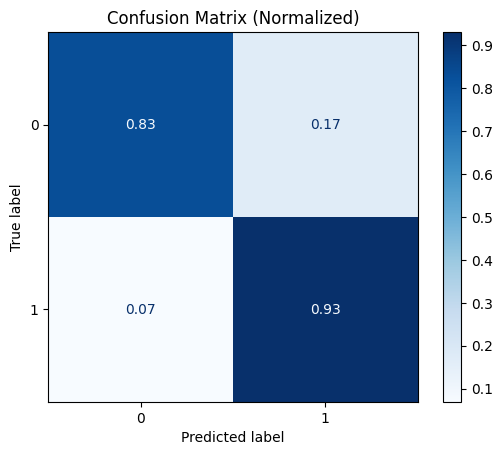

True Positives (TP): 20717
True Negatives (TN): 1517
False Positives (FP): 308
False Negatives (FN): 1550
Total wrong predictions (FP + FN): 1858


In [83]:
# jika y_val adalah true labels dan y_preds adalah label yang diprediksi
cm = confusion_matrix(y_val, y_preds)

# normalisasi confusion matrix untuk melihatkan proportions (decimal)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# memperlihatkan confusion matrix dengan counts dan decimal
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Normalized)')
plt.show()

# ngeprint setiap kategori (TP, FP, TN, FN)
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# mengeprint total prediksi yang salah
wrong_predictions = FP + FN
print(f"Total wrong predictions (FP + FN): {wrong_predictions}")

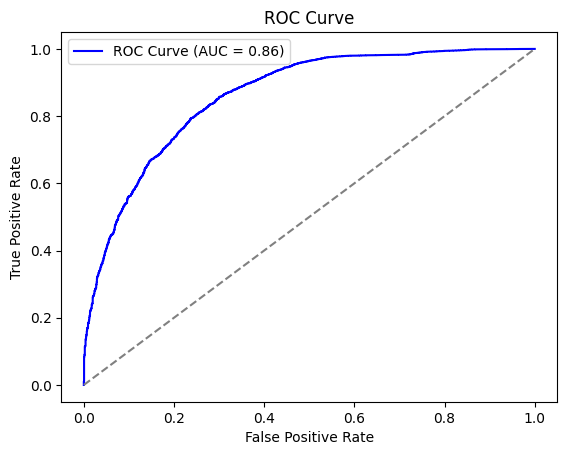

In [84]:
y_proba = gnb.predict_proba(X_val_transformed)[:, 1] 

fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [85]:
convert_data_types(df_train)
missingDataHandler(df_train)
outlierHandler(df_train)
duplicateHandler(df_train)
df_train = featureEngineeringHandler(df_train)

convert_data_types(df_test)
missingDataHandler(df_test)
outlierHandler(df_test)
# duplicateHandler(df_test)
df_test = featureEngineeringHandler(df_test)

In [86]:
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

X_train_transformed = pipe.named_steps['preprocessor'].transform(X_train)

In [ ]:
#jeger

NameError: name 'jeger' is not defined

In [ ]:
class NaiveBayesWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.model = NaiveBayes()

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

param_grid = {'var_smoothing': [1e-11, 2e-11, 5e-11, 1e-10, 2e-10, 5e-10, 1e-9, 5e-9, 1e-8]}
grid_search = GridSearchCV(NaiveBayesWrapper(), param_grid, cv=5)
grid_search.fit(X_train_transformed, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'var_smoothing': 1e-11}


: 

In [ ]:
param_dist = {'var_smoothing': np.logspace(-10, -5, 100)}
random_search = RandomizedSearchCV(NaiveBayesWrapper(), param_dist, n_iter=50, cv=5)
random_search.fit(X_train_transformed, y_train)
print("Best parameters:", random_search.best_params_)

In [ ]:
def objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-9, 1e-7)
    
    model = NaiveBayes(var_smoothing=var_smoothing)
    
    # melakukan cross validation dan memprediksi setiap fold
    y_pred = cross_val_predict(model, X_train_transformed, y_train, cv=5)
    
    # mengkalkulasi hasil F1 untuk label 0
    f1_label_0 = f1_score(y_train, y_pred, labels=[0], average=None)[0]
    
    return f1_label_0

# membuat study dan mengoptimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best F1 score for label 0:", study.best_value)

In [ ]:
X_train = df_train.drop(columns=['label']) 
y_train = df_train['label']

# model dengan optimal var_smoothing dari tuning
model = NaiveBayes(var_smoothing=1.765064908382729e-08) 

# stratified k-Fold (5-fold cross-validation, mengubah n_splits)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# list untuk menyimpan accuracy score
stratified_scores = []

for train_index, test_index in stratified_kfold.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_train_fold_transformed = pipe.named_steps['preprocessor'].fit_transform(X_train_fold)
    X_test_fold_transformed = pipe.named_steps['preprocessor'].transform(X_test_fold)

    model.fit(X_train_fold_transformed, y_train_fold)
    
    y_pred = model.predict(X_test_fold_transformed)
    
    score = accuracy_score(y_test_fold, y_pred)
    stratified_scores.append(score)

print(f"Stratified k-Fold cross-validation scores: {stratified_scores}")
print(f"Mean stratified k-Fold accuracy score: {np.mean(stratified_scores)}")
print(f"Standard deviation of the scores: {np.std(stratified_scores)}")

X_val_transformed = pipe.named_steps['preprocessor'].transform(X_val)
y_val_pred = model.predict(X_val_transformed)
print(f"Validation set accuracy: {accuracy_score(y_val, y_val_pred)}")

## D. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `label` column.

Note: Adjust step 1 and 2 to your implementation of the preprocessing step if you don't use pipeline API from `sklearn`.

In [88]:
idTest = df_test['id'].copy().values

len(idTest)

10000

In [89]:
numerical_features = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df_train.select_dtypes(include=['category', 'object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', FeatureScaler(), numerical_features),
        ('encoder', FeatureEncoder(), categorical_features)
    ]
)

pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('undersampler', NearMiss(version=3,n_neighbors=3 , sampling_strategy=0.1)),  # NearMiss-3
    ('undersampler', TomekLinks(sampling_strategy='auto')),
    # ('oversampler', CustomRandomOversampler(random_state=42))  #  custom oversampler 
])

X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

X_submission,y_submission = pipe.fit_resample(X_train, y_train)
X_test = pipe.named_steps['preprocessor'].transform(df_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("\nResampled training class distribution:")
print(pd.Series(y_submission).value_counts())

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original training class distribution:
label
True     89673
False     7241
Name: count, dtype: Int64

Resampled training class distribution:
label
True     88545
False     7241
Name: count, dtype: Int64


In [90]:
gnb.fit(X_submission,y_submission)

y_predsi = gnb.predict(X_test)

sub = pd.DataFrame({'id': idTest, 'label': y_predsi})

sub

,id,label
0,48,1
1,68,0
2,76,1
3,155,0
4,167,0
...,...,...
9995,235694,0
9996,235718,0
9997,235733,0
9998,235740,1


In [91]:
validation1 = pd.read_csv('submission_Bayes.csv')
validation2 = pd.read_csv('submission_Bayes2.csv')
sub['label'] = sub['label'].astype(int)
sub.loc[sub['label']==0]

,id,label
1,68,0
3,155,0
4,167,0
6,207,0
9,233,0
...,...,...
9990,235590,0
9992,235597,0
9995,235694,0
9996,235718,0


In [92]:
conf_matrix = confusion_matrix(validation1['label'], sub['label'])
print(f"Confusion Matrix:\n{conf_matrix[0]}")
print(conf_matrix[1])

accuracy = accuracy_score(validation1['label'], sub['label'])
print(f"\nAccuracy: {accuracy:.4f}")

class_report = classification_report(validation1['label'], sub['label'], zero_division=0)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[5186    1]
[ 102 4711]

Accuracy: 0.9897
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5187
           1       1.00      0.98      0.99      4813

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [93]:
conf_matrix = confusion_matrix(validation2['label'], sub['label'])
print(f"Confusion Matrix:\n{conf_matrix[0]}")
print(conf_matrix[1])

accuracy = accuracy_score(validation2['label'], sub['label'])
print(f"\nAccuracy: {accuracy:.4f}")

class_report = classification_report(validation2['label'], sub['label'], zero_division=0)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[5288    0]
[   0 4712]

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5288
           1       1.00      1.00      1.00      4712

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [46]:
# breaker, hilangkan comment biar ga langsung ngesave

In [180]:
# save dataframe menjadi csv
sub.to_csv('submission.csv', index=False)

In [94]:
gnb.save('gnbModel.pkl') #simpan model

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

1. Apakah perbedaan perlakuan pada tiap missing data berpengaruh pada prediksi?
2. Berpakah treshold terbaik dalam penentuan outlier dengan metode IQR?
3. Data duplikat mana yang sebaiknya di drop? mengapa?
4. Apa yang terjadi jika dilakukan penambahan jenis kategori dari numerical pada feature engineering?
5. Apakah feature scaling membantu meningkatkan performa model?
6. Apakah feature encoding membantu meningkatkan performa model?
7. Metode apakah yang terbaik? oversampling, undersampling, atau keduanya? mengapa?
8. Bagaimanakah ukuran data yang ditrain dalam algoritma KNN mempengaruhi performa prediksi?
9. Apakah eps mempengaruhi hasil prediksi pada algoritma gaussian naive bayes? mengapa perlu ada eps dalam perhitungan?
#### Jawab
1. Ya, selain untuk menghindari error yang terjadi (seperti menggunakan metode mean pada data tipe object), perbedaan perlakuan dapat menghindari terjadi nya bias yang terjadi dari banyak nya data yang diisi.
2. Setelah banyak percobaan, pada kasus ini kami percaya bahwa threshold = 1 adalah yang terbaik dan dibuktikan dengan hasil yang lebih baik dengan treshold treshold lain (1.5, 1.2, etc).
3. Kami memilih column URL sebagai patokan dalam drop duplicates dikarenakan sebagai data pengecekan link phishing, link URL yang sama tidak seharusnya memiliki label yang berbeda, sehingga kami membuang duplicates dari URL untuk menghindarinya.
4. Penambahan fitur categorical dapat membantu agent dalam kecepatan learning dan membantu dalam prediksi akibat penambahan kategori berarti setiap row semakin distinct.
5. Ya, dengan membatasi range value dari kolom dapat membantu algoritma KNN karena mempunyai skala yang sama dan mengindari bias dalam penentuan distance.
6. Ya, dengan mengganti categorical menjadi beberapa kolom binary dapat meningkatkan kecepatan program. Selain itu, encoding ini meningkatkan ke-distict-an setiap data.
7. Berdasarkan percobaan yang telah kami lakukan, kami percaya bahwa metode undersampling dengan metode TOMEK merupakan pilihan terbaik. Hal ini mungkin saja terjadi dikarenakan metode undersampling lain terlalu mengurangi data yang berharga, dan oversampling bisa mengakibatkan noise dari keseluruhan data.
8. Pada algoritma KNN, data yang lebih banyak meningkatkan presisi dari prediksi, namun menurunkan kecepatan dari prediksi dengan cukup signifikan.
9. Pada algoritma Gaussian Naive Bayes, secara mengejutkan penambahan eps dapat mempengaruhi hasil yang didapatkan dari prediksi, kami menduga bahwa hal ini bisa saja terjadi dikarenakan angka perhitungan yang terlalu kecil sehingga angka eps tertentu bisa mempengaruhi kinerja prediksi.